In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
import random


In [11]:
class DataGenerator(Sequence):
    def __init__(self, image_filenames, mask_filenames, image_folder, mask_folder, batch_size=1, img_size=(256, 256)):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.batch_size = batch_size
        self.img_size = img_size
        self.indexes = np.arange(len(self.image_filenames))
    
    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.image_filenames[k] for k in indexes]
        batch_masks = [self.mask_filenames[k] for k in indexes]
        images, masks = self.__load_batch(batch_images, batch_masks)
        return images, masks
    
    def __load_batch(self, batch_images, batch_masks):
        images = []
        masks = []
        for img_file, mask_file in zip(batch_images, batch_masks):
            img = load_img(os.path.join(self.image_folder, img_file), target_size=self.img_size)
            img = img_to_array(img) / 255.0
            mask = load_img(os.path.join(self.mask_folder, mask_file), target_size=self.img_size, color_mode='grayscale')
            mask = img_to_array(mask) / 255.0
            images.append(img)
            masks.append(mask)
        return np.array(images), np.array(masks)


In [12]:
dataset_path = "/kaggle/input/flood-dataset/flood detection dataset"
image_folder =  f"{dataset_path}/Image"
mask_folder = f"{dataset_path}/Mask"
if os.path.exists(image_folder) and os.path.exists(mask_folder):
    image_filenames = sorted(os.listdir(image_folder))
    mask_filenames = sorted(os.listdir(mask_folder))

    

In [13]:
from sklearn.model_selection import train_test_split

# Split dataset into train (70%), validation (20%), and test (10%)
train_images, temp_images, train_masks, temp_masks = train_test_split(
    image_filenames, mask_filenames, test_size=0.2, random_state=42
)

val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.33, random_state=42  # 33% of 30% → 10% of total dataset
)

# Create data generators
train_generator = DataGenerator(train_images, train_masks, image_folder, mask_folder, batch_size=1)
val_generator = DataGenerator(val_images, val_masks, image_folder, mask_folder, batch_size=1)
test_generator = DataGenerator(test_images, test_masks, image_folder, mask_folder, batch_size=1)

# Print dataset sizes
print(f"Training set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")
print(f"Test set: {len(test_images)} images")


Training set: 231 images
Validation set: 38 images
Test set: 20 images


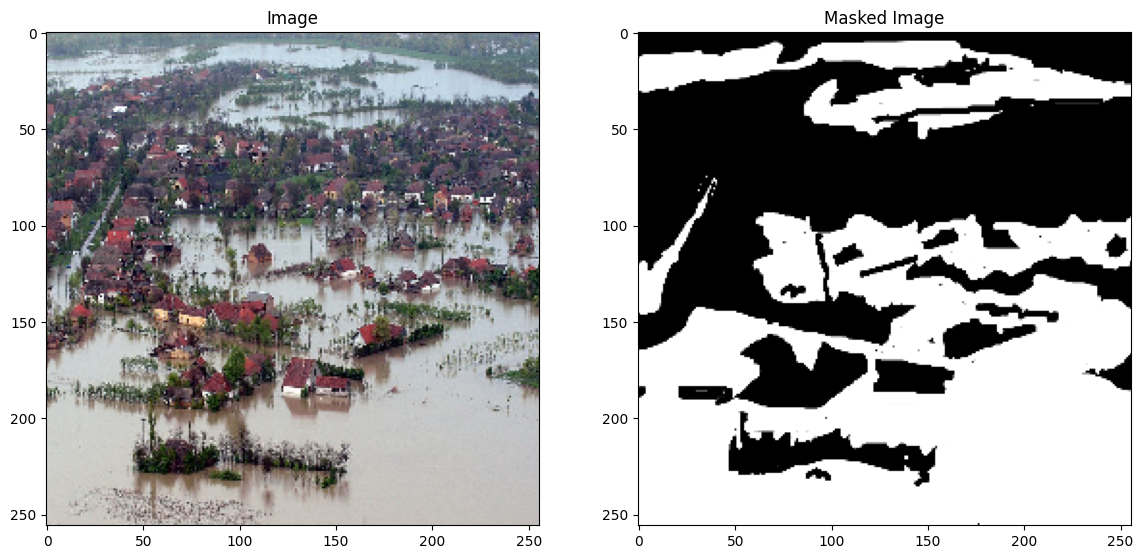

In [14]:
random_image_id = random.randint(0, len(train_generator) - 1)
sample_image, sample_mask = train_generator[random_image_id]

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(sample_image[0])  # Extract the first image from batch
plt.title("Image")

plt.subplot(122)
plt.imshow(sample_mask[0].squeeze(), cmap='gray')  # Extract and squeeze mask
plt.title("Masked Image")
plt.show()


In [ ]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from math import log2
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

def mlp(x, cf):
    x = L.Dense(cf["mlp_dim"], activation="gelu")(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    x = L.Dense(cf["hidden_dim"])(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = L.LayerNormalization()(x)
    x = L.MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = L.Add()([x, skip_1])

    skip_2 = x
    x = L.LayerNormalization()(x)
    x = mlp(x, cf)
    x = L.Add()([x, skip_2])

    return x

def conv_block(x, num_filters, kernel_size=3):
    x = L.Conv2D(num_filters, kernel_size=kernel_size, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)
    return x

def deconv_block(x, num_filters, strides=2):
    x = L.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=strides)(x)
    return x

def build_unetr_2d(cf):
    input_shape = (cf["image_size"], cf["image_size"], cf["num_channels"])
    inputs = L.Input(input_shape)  
    patch_embed = L.Conv2D(
    filters=cf["hidden_dim"], 
    kernel_size=cf["patch_size"], 
    strides=cf["patch_size"], 
    padding="valid"
    )(inputs)

    patch_embed = L.Reshape((-1, cf["hidden_dim"]))(patch_embed) 
    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)
    pos_embed = L.Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions)
    x = patch_embed + pos_embed

    skip_connection_index = [3, 6, 9, 12]
    skip_connections = []

    for i in range(1, cf["num_layers"]+1, 1):
        x = transformer_encoder(x, cf)
        if i in skip_connection_index:
            skip_connections.append(x)
    z3, z6, z9, z12 = skip_connections
    z0 = L.Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(inputs)
    shape = (cf["image_size"]//cf["patch_size"], cf["image_size"]//cf["patch_size"], cf["hidden_dim"])
    z3 = L.Reshape(shape)(z3)
    z6 = L.Reshape(shape)(z6)
    z9 = L.Reshape(shape)(z9)
    z12 = L.Reshape(shape)(z12)

    total_upscale_factor = int(log2(cf["patch_size"]))
    upscale = total_upscale_factor - 4

    if upscale >= 2:
        z3 = deconv_block(z3, z3.shape[-1], strides=2**upscale)
        z6 = deconv_block(z6, z6.shape[-1], strides=2**upscale)
        z9 = deconv_block(z9, z9.shape[-1], strides=2**upscale)
        z12 = deconv_block(z12, z12.shape[-1], strides=2**upscale)

    if upscale < 0:
        p = 2**abs(upscale)
        z3 = L.MaxPool2D((p, p))(z3)
        z6 = L.MaxPool2D((p, p))(z6)
        z9 = L.MaxPool2D((p, p))(z9)
        z12 = L.MaxPool2D((p, p))(z12)

    x = deconv_block(z12, 128)
    s = deconv_block(z9, 128)
    s = conv_block(s, 128)
    x = L.Concatenate()([x, s])
    x = conv_block(x, 128)
    x = conv_block(x, 128)

    x = deconv_block(x, 64)
    s = deconv_block(z6, 64)
    s = conv_block(s, 64)
    s = deconv_block(s, 64)
    s = conv_block(s, 64)
    x = L.Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    x = deconv_block(x, 32)
    s = deconv_block(z3, 32)
    s = conv_block(s, 32)
    s = deconv_block(s, 32)
    s = conv_block(s, 32)
    s = deconv_block(s, 32)
    s = conv_block(s, 32)
    x = L.Concatenate()([x, s])
    x = conv_block(x, 32)
    x = conv_block(x, 32)

    x = deconv_block(x, 16)
    s = conv_block(z0, 16)
    s = conv_block(s, 16)
    x = L.Concatenate()([x, s])
    x = conv_block(x, 16)
    x = conv_block(x, 16)

    outputs = L.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)

    return Model(inputs, outputs, name="UNETR_2D")


In [24]:

from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU, Precision, Recall

mIoU = MeanIoU(num_classes=2)
precision = Precision()
recall = Recall()

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1_score = 2 * (p * r) / (p + r + K.epsilon())
    return f1_score

def mean_iou(y_true, y_pred):
    return mIoU(y_true, y_pred)

def dice_coefficient(y_true, y_pred):
    smooth = 1.0  
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred)

In [25]:
config = {
    "image_size": 256,   # Adjust as needed
    "patch_size": 16,    # Adjust based on your dataset
    "num_channels": 3,   # Number of input channels (3 for RGB, 1 for grayscale)
    "num_patches": (256 // 16) ** 2,  # Derived from image size and patch size
    "hidden_dim": 768,   # Transformer hidden dimension
    "mlp_dim": 3072,     # Feedforward layer dimension
    "num_heads": 12,     # Number of attention heads
    "num_layers": 12,    # Number of transformer layers
    "dropout_rate": 0.1, # Dropout rate
}

model = build_unetr_2d(config)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
              loss=combined_loss,  
              metrics=["accuracy",dice_coefficient, f1_score, mean_iou, precision, recall])

In [26]:
model_history=model.fit(train_generator, validation_data=val_generator, epochs=20)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


231/231 ━━━━━━━━━━━━━━━━━━━━ 170s 343ms/step - accuracy: 0.6064 - dice_coefficient: 0.4472 - f1_score: 0.2916 - loss: 0.6007 - mean_iou: 0.2794 - precision_3: 0.5384 - recall_3: 0.3875 - val_accuracy: 0.5257 - val_dice_coefficient: 0.5402 - val_f1_score: 0.6720 - val_loss: 0.5638 - val_mean_iou: 0.2982 - val_precision_3: 0.4890 - val_recall_3: 0.9746
Epoch 2/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 72s 312ms/step - accuracy: 0.7765 - dice_coefficient: 0.5913 - f1_score: 0.7154 - loss: 0.4467 - mean_iou: 0.2968 - precision_3: 0.7461 - recall_3: 0.7270 - val_accuracy: 0.7627 - val_dice_coefficient: 0.6467 - val_f1_score: 0.7624 - val_loss: 0.4103 - val_mean_iou: 0.2746 - val_precision_3: 0.7049 - val_recall_3: 0.8237
Epoch 3/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 72s 310ms/step - accuracy: 0.8085 - dice_coefficient: 0.6440 - f1_score: 0.7738 - loss: 0.3964 - mean_iou: 0.2594 - precision_3: 0.7855 - recall_3: 0.7580 - val_accuracy: 0.8071 - val_dice_coefficient: 0.6507 - val_f1_score: 0.7825 - val_loss: 

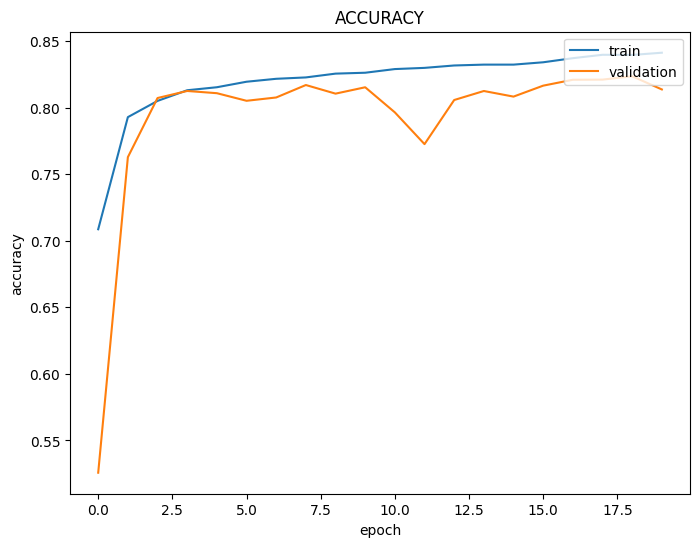

In [27]:
fig,ax11=plt.subplots(figsize=(8,6))
ax11.plot(model_history.history['accuracy'])
ax11.plot(model_history.history['val_accuracy'])
ax11.title.set_text('ACCURACY')
ax11.set_ylabel('accuracy')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper right')

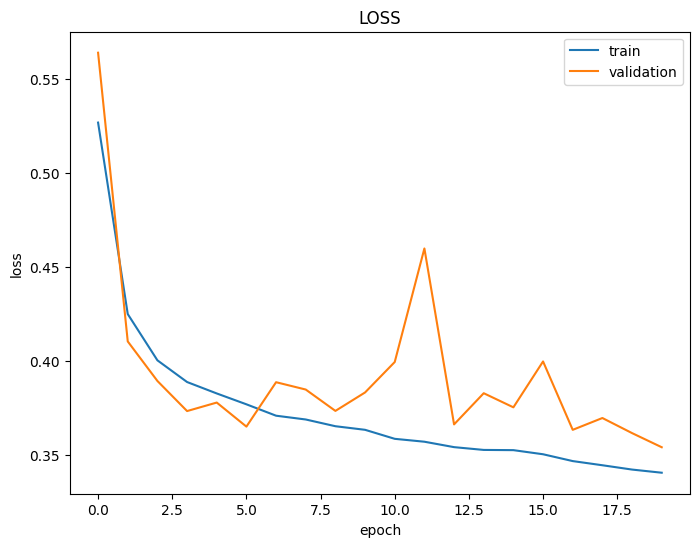

In [28]:
fig,ax12 = plt.subplots(figsize=(8,6))
ax12.plot(model_history.history['loss'])
ax12.plot(model_history.history['val_loss'])
ax12.title.set_text('LOSS')
ax12.set_ylabel('loss')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper right')

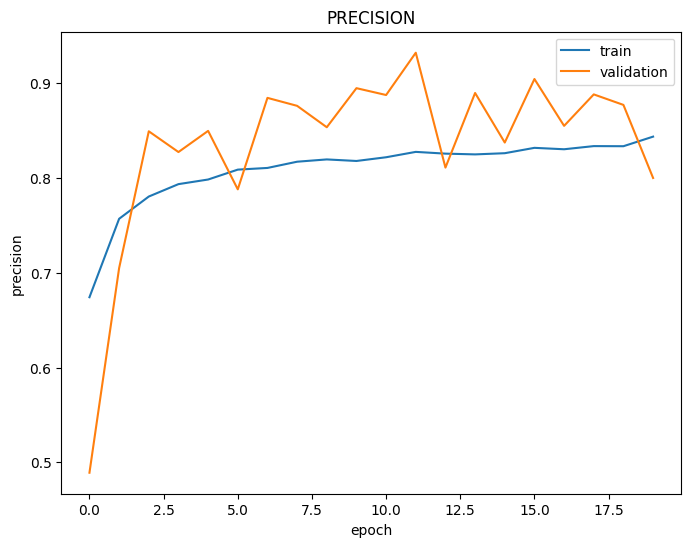

In [30]:
fig,ax13=plt.subplots(figsize=(8,6))
ax13.plot(model_history.history['precision_3'])
ax13.plot(model_history.history['val_precision_3'])
ax13.title.set_text('PRECISION')
ax13.set_ylabel('precision')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper right')

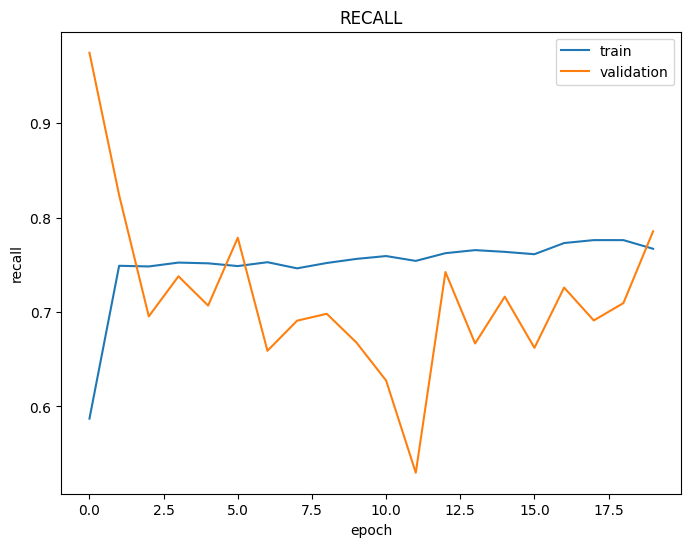

In [32]:
fig,ax14=plt.subplots(figsize=(8,6))
ax14.plot(model_history.history['recall_3'])
ax14.plot(model_history.history['val_recall_3'])
ax14.title.set_text('RECALL')
ax14.set_ylabel('recall')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper right')

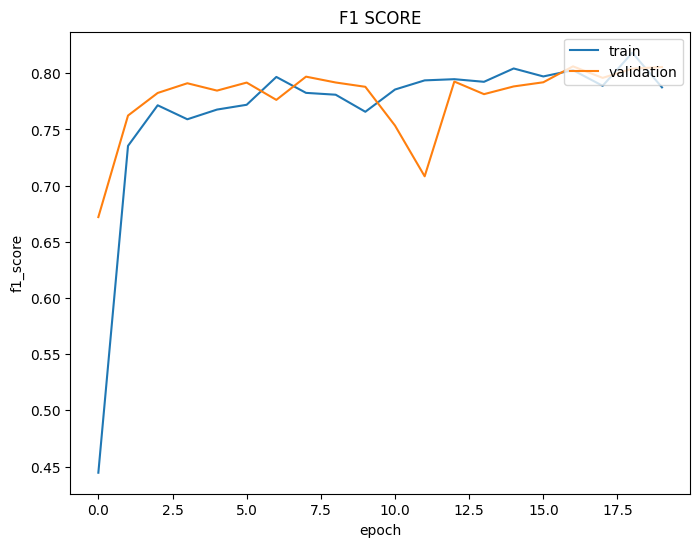

In [33]:
fig,ax15=plt.subplots(figsize=(8,6))
ax15.plot(model_history.history['f1_score'])
ax15.plot(model_history.history['val_f1_score'])
ax15.title.set_text('F1 SCORE')
ax15.set_ylabel('f1_score')
ax15.set_xlabel('epoch')
ax15.legend(['train', 'validation'], loc='upper right')

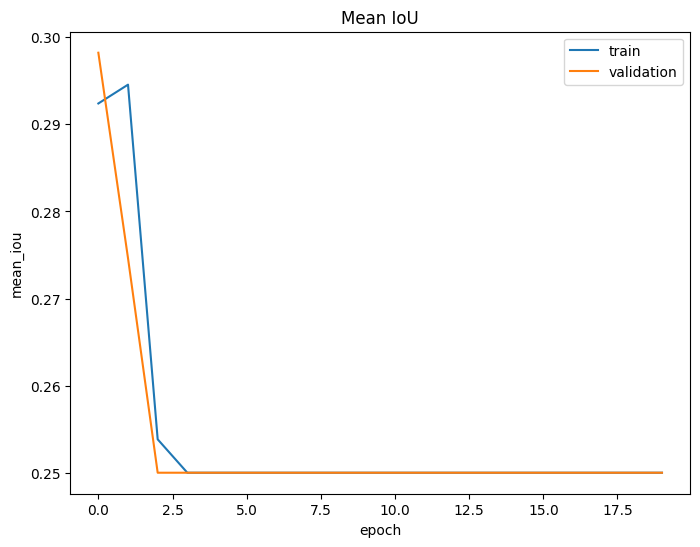

In [34]:
fig,ax16=plt.subplots(figsize=(8,6))
ax16.plot(model_history.history['mean_iou'])
ax16.plot(model_history.history['val_mean_iou'])
ax16.title.set_text('Mean IoU')
ax16.set_ylabel('mean_iou')
ax16.set_xlabel('epoch')
ax16.legend(['train', 'validation'], loc='upper right')

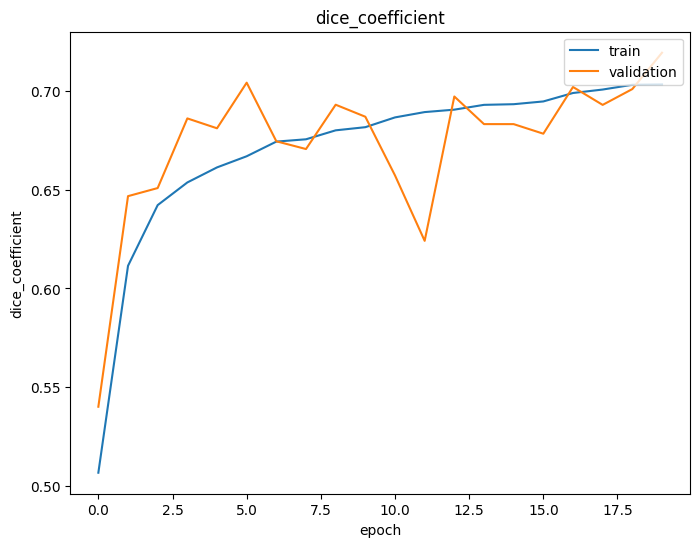

In [36]:
fig,ax17=plt.subplots(figsize=(8,6))
ax17.plot(model_history.history['dice_coefficient'])
ax17.plot(model_history.history['val_dice_coefficient'])
ax17.title.set_text('dice_coefficient')
ax17.set_ylabel('dice_coefficient')
ax17.set_xlabel('epoch')
ax17.legend(['train', 'validation'], loc='upper right')

In [37]:
pred_masks = model.predict(test_generator)
pred_masks = (pred_masks > 0.5).astype(np.uint8)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step


In [38]:
loss,dice_coefficient, accuracy, f1_score, precision, recall,mean_iou = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"dice coefficient: {dice_coefficient:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test MeanIoU: {mean_iou:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.8737 - dice_coefficient: 0.7399 - f1_score: 0.8792 - loss: 0.2801 - mean_iou: 0.2500 - precision_3: 0.8611 - recall_3: 0.8614
Test Loss: 0.3018
dice coefficient: 0.8727
Test Accuracy: 0.6962
Test F1 Score: 0.8636
Test Precision: 0.2500
Test Recall: 0.8214
Test MeanIoU: 0.8481


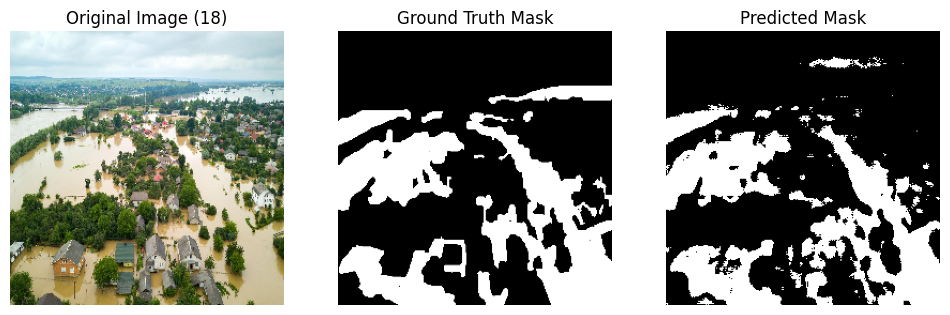

In [39]:
import random
import numpy as np
import matplotlib.pyplot as plt

def visualize_random_prediction(test_generator, pred_masks):
    # Select a random index from the test set
    idx = random.randint(0, len(test_generator) - 1)

    # Load a batch (assuming batch_size=1 for visualization)
    test_image, test_mask = test_generator[idx]  # Returns (image, mask)

    # Remove batch dimension
    test_image = test_image[0]  # Shape: (H, W, C)
    test_mask = test_mask[0].squeeze()  # Shape: (H, W)
    pred_mask = pred_masks[idx].squeeze()  # Ensure same shape

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title(f"Original Image ({idx})")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(test_mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

# Call the function
visualize_random_prediction(test_generator, pred_masks)